In [1]:
import numpy as np
import sys
from typing import List, Dict, Iterable, Tuple
import json
sys.setrecursionlimit(100000)
import tqdm

from Read import Read
from Gene import Gene
from OverlapAlignment import OverlapVDJAlignment

def KeepHighScoreAlignments(data: Dict, threshold: int) -> Dict:
    """
    Keep reads with high scores

    Parameters
    ----------
    data : Dict, data
    threshold : int, threshold for the score
    """
    overlap_results, random_results = data['overlap'], data['random']
    all_epitopes, all_v_genes, all_j_genes = data['all_epitopes'], data['all_v_genes'], data['all_j_genes']

    high_score_overlap = [result for result in overlap_results if result['final_score'] > threshold]
    high_score_random = [result for result in random_results if result['final_score'] > threshold]

    final_json = {
        'high_score_overlap': high_score_overlap,
        'high_score_random': high_score_random,
        'all_epitopes': all_epitopes,
        'all_v_genes': all_v_genes,
        'all_j_genes': all_j_genes
    }

    return final_json

def AlignAllReads(match_reward: int, mismatch_penalty: int, indel_penalty: int,
                  overlap_match_score: int, overlap_mismatch_score: int,
                  data: Dict) -> List:
    """
    Perform overlap alignment between V, D, and J genes and reads

    Parameters
    ----------
    match_reward : int, reward for matching nucleotides
    mismatch_penalty : int, penalty for mismatching nucleotides
    indel_penalty : int, penalty for indels
    overlap_match_score : int, reward for matching nucleotides in the overlap region
    overlap_mismatch_score : int, penalty for mismatching nucleotides in the overlap region
    data : Dict, data
    """
    all_epitopes, all_v_genes, all_j_genes, overlap_reads, random_reads = \
        data['epitopes'], data['v_genes'], data['j_genes'], data['overlap_reads'], data['random_reads']
    
    results_overlap = []
    print('Aligning overlap reads')
    for read in tqdm.tqdm(overlap_reads):
        result = AlignOneRead(match_reward, mismatch_penalty, indel_penalty, 
                              overlap_match_score, overlap_mismatch_score, all_v_genes, all_j_genes, read)
        results_overlap.append(result)

    results_random = []
    print('\nAligning random reads')
    for read in tqdm.tqdm(random_reads):
        result = AlignOneRead(match_reward, mismatch_penalty, indel_penalty, 
                                overlap_match_score, overlap_mismatch_score, all_v_genes, all_j_genes, read)
        results_random.append(result)

    final_json = {
        'overlap': results_overlap,
        'random': results_random,
        'all_epitopes': all_epitopes,
        'all_v_genes': all_v_genes,
        'all_j_genes': all_j_genes
    }
    return final_json


def AlignOneRead(match_reward: int, mismatch_penalty: int, indel_penalty: int,
                 overlap_match_score: int, overlap_mismatch_score: int,
                v_genes: Gene, j_genes: Gene, read: Read) -> Dict:
    """
    Perform overlap alignment between V, D, and J genes and a read

    Parameters
    ----------
    match_reward : int, reward for matching nucleotides
    mismatch_penalty : int, penalty for mismatching nucleotides
    indel_penalty : int, penalty for indels
    overlap_match_score : int, reward for matching nucleotides in the overlap region
    overlap_mismatch_score : int, penalty for mismatching nucleotides in the overlap region
    v_genes : Gene, V genes
    j_genes : Gene, J genes
    read : Read, read
    """
    best_score = -np.inf
    best_result = None
    for v_gene in v_genes:
        for j_gene in j_genes:
            result = OverlapVDJAlignment(match_reward, mismatch_penalty, indel_penalty, overlap_match_score,
                                        overlap_mismatch_score, v_gene, j_gene, read, False)
            if result['final_score'] > best_score:
                best_score = result['final_score']
                best_result = result
    return best_result


In [10]:
with open('./Simulation/sim_1.json') as f:
    data = json.load(f)
    data = {k: [Gene(**d) for d in v] if k in ['v_genes', 'j_genes'] else [Read(**d) for d in v] if k in ['overlap_reads', 'random_reads'] else v for k, v in data.items()}

match_reward, mismatch_penalty, indel_penalty = 1, 1, 1
overlap_match_score, overlap_mismatch_score = 1, 1
threshold = 5
final_json = AlignAllReads(match_reward, mismatch_penalty, indel_penalty, overlap_match_score, overlap_mismatch_score, data)
# final_json = KeepHighScoreAlignments(final_json, threshold)

Aligning overlap reads


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]



Aligning random reads


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


In [11]:
overlap_scores = [i['final_score'] for i in final_json['overlap']]
random_scores = [i['final_score'] for i in final_json['random']]

In [8]:
final_json

{'overlap': [{'final_score': 40,
   'aligned_v_tail': 'TTGAANCAAACAAGCTTGGGTCATC',
   'aligned_read_head': 'TTGAANCAAACAAGCTTGGGTCATC',
   'v_gene_epi': ['PICCNFVKD'],
   'aligned_read_tail': 'AAGCT-TGGGTCATCTGAGGAGACGGACAACC-GGT-CTTCCCCCCAAACCGATC-TCCAAT-TGACTA',
   'aligned_j_head': 'TA-CTATGAGTC--CT-A-CA-ACATACAGCCACCTCCTCCCCCCCAAA---ATCAAGTAATGAGACTA',
   'j_gene_epi': ['VFWSMQRDE']},
  {'final_score': 26,
   'aligned_v_tail': 'AGTC--GCGCTCA-GCAATC-ATA-TCTACTG-TTCCTACGTATCAACCCGCCAAACACCCGCTTTCGTCTTGCA-GTGT',
   'aligned_read_head': 'AGCCATGCACGAATGGAATCGCTAGT-TACGGCTTCCGGGGTGTGAA---GCTANCCA-CTGC-TCCGTC--GCACGCGT',
   'v_gene_epi': ['PCDMVLKNK',
    'DGSNEHDDV',
    'IMMYFAGME',
    'DCFPHVAYL',
    'PICCNFVKD',
    'EFLPHFANY',
    'VFWSMQRDE',
    'WHERHLSEH',
    'WIVFFYMLD'],
   'aligned_read_tail': 'GAATGG-AATCG-CTAG--TTACGGCTTCCGGGG-T--G-TGAAGCTANC-CAC-TGC-TCCGTCGCACGCGTCAG',
   'aligned_j_head': 'GTA-GGCGGTCGCCTTGCCTGACGGGGT-CGGGGCTGGGTTGAAG-AAGCGCGCATACAAAC-TGGGACG-GGCAG',


In [12]:
print("Average overlap score:", np.mean(overlap_scores))
print("Average random score:", np.mean(random_scores))

Average overlap score: 64.44
Average random score: 24.2


(array([ 2.,  1.,  1.,  1.,  3.,  3.,  0.,  6.,  9., 12., 14., 15., 11.,
         0.,  5., 10.,  3.,  2.,  1.,  1.]),
 array([15.  , 15.85, 16.7 , 17.55, 18.4 , 19.25, 20.1 , 20.95, 21.8 ,
        22.65, 23.5 , 24.35, 25.2 , 26.05, 26.9 , 27.75, 28.6 , 29.45,
        30.3 , 31.15, 32.  ]),
 <BarContainer object of 20 artists>)

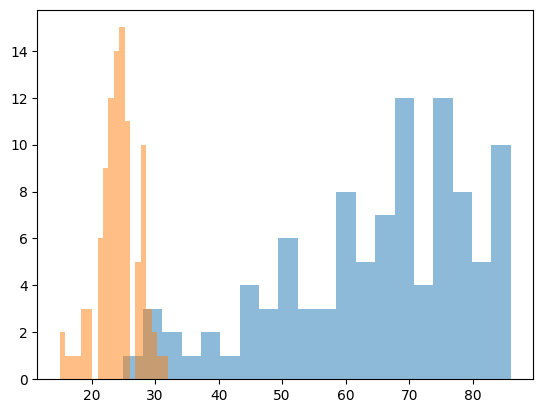

In [13]:
# Plot the distribution of scores
import matplotlib.pyplot as plt
plt.hist(overlap_scores, bins=20, alpha=0.5, label='overlap')
plt.hist(random_scores, bins=20, alpha=0.5, label='random')